### Importing libraries and setting some global settings

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import Generator, PCG64
import time
plt.rcParams['text.usetex'] = True

### JCIR basics
The JCIR model is an extension of the CIR model. The tracked quantity (in our case an intensity $\lambda$) moves according to the dynamics

$$d \lambda_t = \kappa(\mu_\lambda - \lambda_t) dt + v_\lambda\sqrt{\lambda_t}dZ_t + dJ_t ^{\alpha, \gamma} $$


where $\mu_\lambda$ represent the standard $\lambda$ that is reverted to, $\kappa$ is the reversion speed, $v_\lambda$ is the diffusion variance, and $dJ_t^{\alpha, \gamma}$ is a jump process with jump arrival rate $\alpha$ and jump sizes drawn from an exponential distribution with mean $\gamma$. (See e.g. Brigo Book pg. 76)

### Euler Maruyama implementation
One way to implement the JCIR process is to run an euler marayuma process for the diffusion element, and to simulate a list of jumps beforehand which are inserted when they occur, this is demonstrated in the first code cell below.


Jump Times: [ 0.46820277  3.76399414  4.70976291 28.78480806 30.12005985]
Jump Intensities: [0.009192440895499632, 0.00925716338876318, 0.0021870210045678413, 0.07026757579207397, 0.035222803118632656]
--- 0.029918909072875977 seconds ---


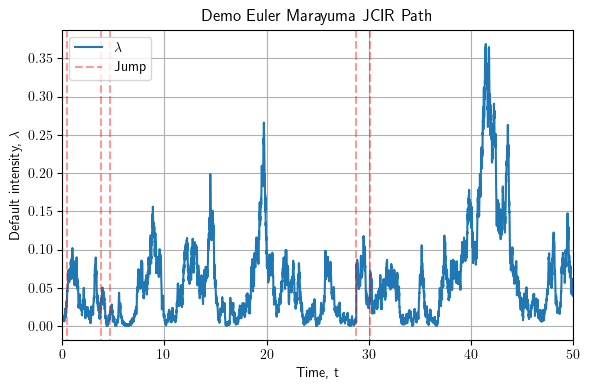

In [ ]:
t0 = 0
T = 50

lambda0 = 0.01
mu = 0.05
kappa = 0.5
v = 0.25

alpha = 5/T # We should expect to see about 5 jumps,
gamma = mu # With expected size mu

rand = Generator(PCG64())

## Generate Jumps
jump_times = t0 + (T-t0)*rand.random(rand.poisson(alpha*(T-t0),))  # The inner random generates the event count and the outer distributes them in time geometrically
jump_times.sort()
jump_intensitys = [rand.exponential(gamma) for a in jump_times] # Draws exponential intensities for each of the jumps
print("Jump Times: " + str(jump_times))
print("Jump Intensities: " + str(jump_intensitys))

jumps = list(zip(jump_times,jump_intensitys)) # A list of tuples of ordered times and intensities


## Run diffusion model for let's say the dt = 1/128 used by Atroshi Sibai
N = (T-t0)*128
t_s = np.linspace(t0,T,N)
t_s = np.concatenate((t_s,jump_times))
t_s.sort()
lambdas = np.linspace(lambda0,lambda0,len(t_s))
gen_noise = (rand.normal(0,1,(len(t_s))))

# Time the run (this is very unscientific)
strt_time = time.time()

for i in np.arange(1,len(t_s)):
    dt = t_s[i]-t_s[i-1]
    dW = np.sqrt(dt)*gen_noise[i]
    lambdas[i] = lambdas[i-1] + kappa*(mu-lambdas[i-1])*dt + v*np.sqrt(lambdas[i-1])*dW

    # Add jump
    if not not jumps:
        if jumps[0][0] == t_s[i]:
            lambdas[i] = lambdas[i] + jumps[0][1]
            jumps.pop(0)
            
    # Force positivity in case of unlikely failure
    lambdas[i] = max(lambdas[i],0)
    
print("--- %s seconds ---" %(time.time()-strt_time))

fig1, ax1 = plt.subplots(figsize = (6,4), tight_layout = True)
ax1.plot(t_s,lambdas,label = r"$\lambda$")
ax1.set_title("Demo Euler Marayuma JCIR Path")
ax1.set_xlabel("Time, t")
ax1.set_ylabel(r"Default intensity, $\lambda$")
ax1.set_xlim((t0,T))
ax1.grid(True)
lims = ax1.get_ylim()
ax1.vlines(jump_times,lims[0]-2,lims[1]+2,colors=('red',0.4),label="Jump",linestyles=['dashed'])
ax1.legend()
ax1.set_ylim(lims)
plt.show()



### A Transformed Implementation with Second Order Corrections
We can transform the problem into one on the square root of $\lambda_t$, if we name this variable $Y_t$, and discard the jumps for now we get the new SDE for non jump moments (Itô).
$$\lambda_t = Y_t^2 $$
$$dY_t = \left(\frac{(4\kappa\mu_\lambda - v^2) Y_t^{-1} - (4\kappa)Y_t}{8} \right)dt + \frac{1}{2}v_{\lambda}dW_t$$
$$ := a dt + bdW_t$$
We can run this between jumps and add them when they arrive as we did for the Euler case, but we can further improve on the model by making an order two approximation as suggested by Klunkar<sup>1</sup> in Liberati<sup>2</sup>;
$$Y_{t+1-} = Y_{t} + a\Delta_t + b\Delta_W + \frac{bb'}{2} \left( (\Delta W)^2 - \Delta_t \right) + \frac{1}{2}\left(aa' + \frac{1}{2}a''b^2 \right)\Delta_t^2 + \frac{1}{2}\left(a'b + ab' + \frac{1}{2}b''b^2 \right)\Delta_W\Delta_t$$
where $a' = \frac{da}{dY}$ which gives 
$$a = \left(\frac{(4\kappa\mu_\lambda - v^2)Y_t^{-1} - (4 \kappa )Y_t}{8} \right)$$
$$a' = \left(\frac{-(4\kappa \mu_\lambda - v^2)Y_t^{-2} - (4 \kappa)}{8} \right)$$
$$a'' = \left(\frac{(4\kappa \mu_\lambda - v^2)Y_t^{-3}}{4} \right)$$
$$b = (\frac{1}{2}v_\lambda)$$
$$b' = b'' = 0$$
Then we can simplify the equation to;
$$Y_{t+1-} = Y_{t} + a\Delta_t + b\Delta_W + \frac{1}{2}\left(aa' + \frac{1}{2}a''b^2 \right)\Delta_t^2 + \frac{1}{2}\left(a'b\right)\Delta_W\Delta_t$$

1: P. Klunklar, R. Tanadkithirun and P. Boonserm, "Numerical methods for jump-extended Cox-Ingersoll-Ross and constant elasticity of variance models

2: N.B. Liberati and E. Platen, Approximation of jump diffusions in finance
and economics. , Comput Econ, 2007, pp. 283–312.

Jump Times: [ 0.51469132 27.65587811 49.14806824]
Jump Intensities: [0.5405742825924612, 1.9578103472052082, 0.22054040176228493]
--- 0.0009975433349609375 seconds ---


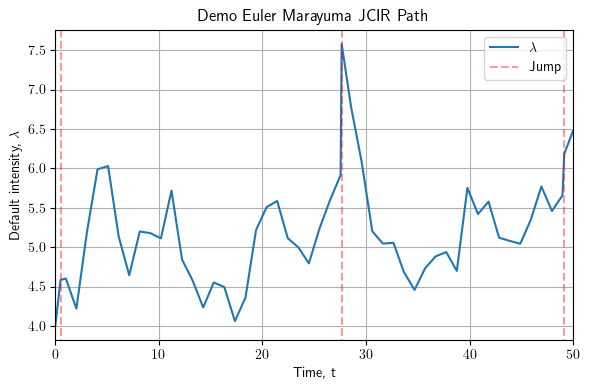

In [15]:
# Recreate the jump list
print("Jump Times: " + str(jump_times))
print("Jump Intensities: " + str(jump_intensitys))
jumps = list(zip(jump_times,jump_intensitys)) # A list of tuples of ordered times and intensities

## Clear lambdas to preven cross contamination, preallocate transformed var
Y_s = np.linspace(np.sqrt(lambda0), np.sqrt(lambda0), len(t_s)) 
lambdas = np.linspace(lambda0,lambda0,len(t_s))

## Run and time the transformed model on the same noise
strt_time = time.time()

for i in np.arange(1,len(t_s)):
    dt = t_s[i]-t_s[i-1]
    dW = np.sqrt(dt)*gen_noise[i]
    
    a = ((4*kappa*mu - v**2)*Y_s[i-1]**(-1) - (4*kappa)*Y_s[i-1])/8
    ap = (-(4*kappa*mu - v**2)*Y_s[i-1]**(-2) - (4*kappa))/8
    app = (4*kappa*mu - v**2)*Y_s[i-1]**(-3)/4
    b = (1/2)*v
    Y_s[i] = Y_s[i-1] + a*dt + b*dW + (1/2)*(a*ap - (1/2)*app*b**2)*dt**2 + (1/2)*(ap*b)*dW*dt
    lambdas[i] = Y_s[i]**2

    if not not jumps:
        if t_s[i] == jumps[0][0]:
            lambdas[i] = lambdas[i] + jumps[0][1]
            Y_s[i] = np.sqrt(lambdas[i])
            jumps.pop(0)

print("--- %s seconds ---" %(time.time()-strt_time))

fig1, ax1 = plt.subplots(figsize = (6,4), tight_layout = True)
ax1.plot(t_s,lambdas,label = r"$\lambda$")
ax1.set_title("Demo Euler Marayuma JCIR Path")
ax1.set_xlabel("Time, t")
ax1.set_ylabel(r"Default intensity, $\lambda$")
ax1.set_xlim((t0,T))
ax1.grid(True)
lims = ax1.get_ylim()
ax1.vlines(jump_times,lims[0]-2,lims[1]+2,colors=('red',0.4),label="Jump",linestyles=['dashed'])
ax1.legend()
ax1.set_ylim(lims)
plt.show()

### Commenting on the results
The first concern to be had was with running time, both financial models appear to run very fast and in comparable time, there is no real memory allocation issue, since the models are so light, and the fancier model only uses one extra array of floats with size N.

We can see that for many datapoints they create an essentialy indistiguishable graph which points to that both are working as they should be, when we turn N down to very low numbers (1 to 5 time steps for instance) the fancier model sometimes explodes since the laplace expansion it uses needs somewhat a small dt to work well, and the Y<sup>-3</sup> term leads to large movements when Y is very small, at N = 50 they again appear essentialy identical, so it seems neither is really capturing signifigantly more information than the other.

Frankly either could work, and while the transformed and extended model should perform better in theory as well as being what Klunkar would suggest it exhibits some behavioural quirks that mean we may need to think more about which to use.